In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial.distance import pdist, squareform
import plotly.offline as py
from tqdm import tqdm

# for dataset visibility
pd.set_option('display.max_columns', None)

# Set a seed for reproducibility
np.random.seed(42)
df_merged_clusterB = pd.read_hdf('../ds/cleaned/clustering.h5')
df_merged_clusterB.head()

,date,state,city_or_county,latitude,longitude,congressional_district,participant_age_group1,participant_gender1,min_age_participants,max_age_participants,n_participants_child,n_participants_teen,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1,year,povertyPercentage,n_killed_per_participant,percentage_injured,unharmed_ratio,density_incident_state,males_to_females_ratio,party,candidatevotes,totalvotes
0,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,Adult 18+,Male,26,26,0,0,0,0,1,0,1,2,Shot - Wounded/Injured,2014,16.8,No deaths,58.789954,2.345189,0.136149,2.0,REPUBLICAN,110789,206131
1,2014-01-01,California,Bakersfield,35.3229,-119.0380,23,Adult 18+,Male,28,28,0,0,0,0,2,0,0,2,Shot - Wounded/Injured,2014,14.5,No deaths,45.310907,2.345189,0.639968,2.0,REPUBLICAN,100317,134043
2,2014-01-01,Iowa,Iowa City,41.6611,-91.5302,2,Adult 18+,Female,35,35,0,0,2,0,1,0,1,2,other,2014,10.1,No deaths,71.662763,2.345189,0.096973,0.0,DEMOCRAT,143431,273329
3,2014-01-01,New York,Brooklyn,40.6505,-73.9573,9,Adult 18+,Male,28,30,0,0,1,0,3,0,0,3,Shot - Wounded/Injured,2014,13.4,No deaths,70.237122,2.345189,0.534650,2.0,DEMOCRAT,70997,101606
4,2014-01-01,Colorado,Grand Junction,39.0496,-108.5250,3,Adult 18+,Male,47,47,0,0,0,1,0,0,0,1,"Shot - Dead (murder, accidental, suicide)",2014,10.2,All deaths,43.229167,2.345189,0.097775,1.0,REPUBLICAN,163011,281141


# Density-based clustering

In [57]:
# state with more n_participants
max_participants_state = df_merged_clusterB.groupby('state')['n_participants'].sum().idxmax()
max_participants_count = df_merged_clusterB.groupby('state')['n_participants'].sum().max()
print(f"Lo stato con il numero massimo di partecipanti è '{max_participants_state}' con un totale di {max_participants_count} partecipanti.")

Lo stato con il numero massimo di partecipanti è 'Illinois' con un totale di 21463 partecipanti.


Number of clusters: 20
Cluster 0:
  Centroid: (41.326173590982286, -88.14768792270532)
  Number of killed: 185.0
  Number of injured: 522.0
  Number of participants: 1242.0
---
Cluster 1:
  Centroid: (41.58588687350835, -87.90218695306285)
  Number of killed: 244.0
  Number of injured: 875.0
  Number of participants: 1257.0
---
Cluster 2:
  Centroid: (41.13215816326531, -88.2918581632653)
  Number of killed: 52.0
  Number of injured: 99.0
  Number of participants: 392.0
---
Cluster 3:
  Centroid: (41.48557754237288, -88.09750720338982)
  Number of killed: 74.0
  Number of injured: 259.0
  Number of participants: 708.0
---
Cluster 4:
  Centroid: (41.571516304347824, -87.95517659846547)
  Number of killed: 249.0
  Number of injured: 1103.0
  Number of participants: 1564.0
---
Cluster 5:
  Centroid: (41.53152541073385, -87.9619108433735)
  Number of killed: 240.0
  Number of injured: 856.0
  Number of participants: 1826.0
---
Cluster 6:
  Centroid: (41.5548288973384, -87.9305813688213)
  

/tmp/ipykernel_242000/758786395.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



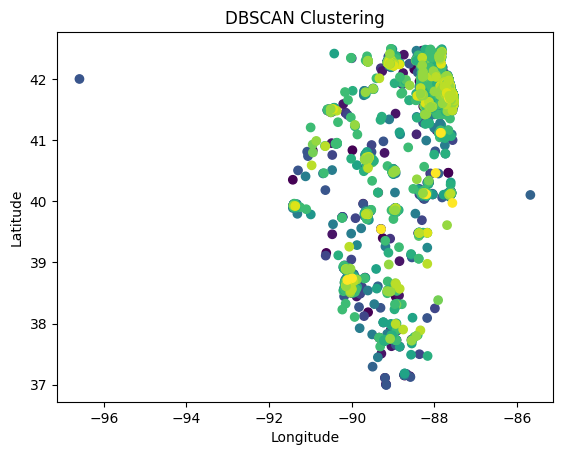

In [58]:
state_df = df_merged_clusterB[df_merged_clusterB['state'] == 'Illinois']

# Seleziona le colonne rilevanti per il clustering
selected_columns = ['latitude', 'longitude']
X = state_df[selected_columns]

# Standardizza i dati Z-score
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Esegui DBSCAN
eps = 0.2  # Sostituisci con il valore appropriato
min_samples = 5  # Sostituisci con il valore appropriato
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
state_df['cluster'] = dbscan.fit_predict(X_scaled)

# Analisi dei parametri di clustering
n_clusters = len(set(state_df['cluster'])) - (1 if -1 in state_df['cluster'] else 0)
print(f'Number of clusters: {n_clusters}')

# Caratterizzazione e interpretazione dei cluster
cluster_stats = state_df.groupby('cluster').agg({
    'latitude': 'mean',
    'longitude': 'mean',
    'n_killed': 'sum',
    'n_injured': 'sum',
    'n_participants': 'sum'
})

# Visualizzazione dei risultati
for cluster_id, row in cluster_stats.iterrows():
    print(f'Cluster {cluster_id}:')
    print(f'  Centroid: ({row["latitude"]}, {row["longitude"]})')
    print(f'  Number of killed: {row["n_killed"]}')
    print(f'  Number of injured: {row["n_injured"]}')
    print(f'  Number of participants: {row["n_participants"]}')
    print('---')

# Visualizzazione della distribuzione dei cluster sulla mappa (usa solo a scopo illustrativo)
plt.scatter(state_df['longitude'], state_df['latitude'], c=state_df['cluster'], cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

k-th nearest neighbour diastance in in order to use Knee Method to estimate the best eps. Multiple values of k

In [59]:

# select just numerical features for the scaling
numeric_columns = df_merged_clusterB.select_dtypes(include=['float64', 'int64']).columns
# new df with just numerical columns
df_numeric = df_merged_clusterB[numeric_columns]
scaler = StandardScaler()
X_std = scaler.fit_transform(df_numeric.values)

In [60]:
#X_scaled
def calc_k_nn_dist_graph(X, ub=0., lb=0.):
    # List of k (for k-th nearest neighbour)
    k_list = [3, 6, 9, 12]

    dist = pdist(X, 'euclidean') #pair wise distance
    dist = squareform(dist) #distance matrix given the vector dist
    
    # Calculate sorted list of distances for points for each k
    for k in k_list:
        kth_distances = list()
        for d in dist:
            index_kth_distance = np.argsort(d)[k]
            kth_distances.append(d[index_kth_distance])

        # Plot the graph of distance from k-th nearest neighbour
        plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
        plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
        plt.xlabel('sorted distances', fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=22)
        plt.grid()
        plt.axhline(ub)
        plt.axhline(lb)

        f = plt.figure()
        f.set_figwidth(4)
        f.set_figheight(1)


        plt.show()
        
        
def db_scan_function (X, eps_list, minpts_list, max_iter_value=300):
    # Table with dim = len(eps_list) x len(minpts)
    dbscan_table = list()

    # Iterate over eps (rows)
    for i, eps in tqdm(enumerate(eps_list)):
        dbscan_table.append([]) 
        # Iterate over minpts
        for minpts in tqdm(minpts_list, leave=False):
            dbscan = DBSCAN(eps=eps, min_samples=minpts, n_jobs=-1)
            dbscan.fit(X)
            dbscan_table[i].append(dbscan)
    
    return dbscan_table        

In [61]:

calc_k_nn_dist_graph(X_std, 0.03, 0.13)

MemoryError: Unable to allocate 67.5 GiB for an array with shape (9055686331,) and data type float64